In [ ]:
# Import The Libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

In [ ]:
!unzip -q Training_age.zip -d /content/
!unzip -q Test_age.zip -d /content/
train_dir = "/content/Training_age"
test_dir = "/content/Test_age"
labels = os.listdir(train_dir)
print('Classes:', labels)

replace /content/Training_age/edad_PR10/103812.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace /content/Test_age/edad_PR10/105002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Classes: ['edad_PT10', 'edad_PR98', 'edad_PR10', 'edad_PR84']


In [ ]:
IMAGE_SIZE = [300,300]
xception = Xception(
    input_shape = IMAGE_SIZE + [3], # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   #
)

83683744/83683744 [==============================] - 0s 0us/step


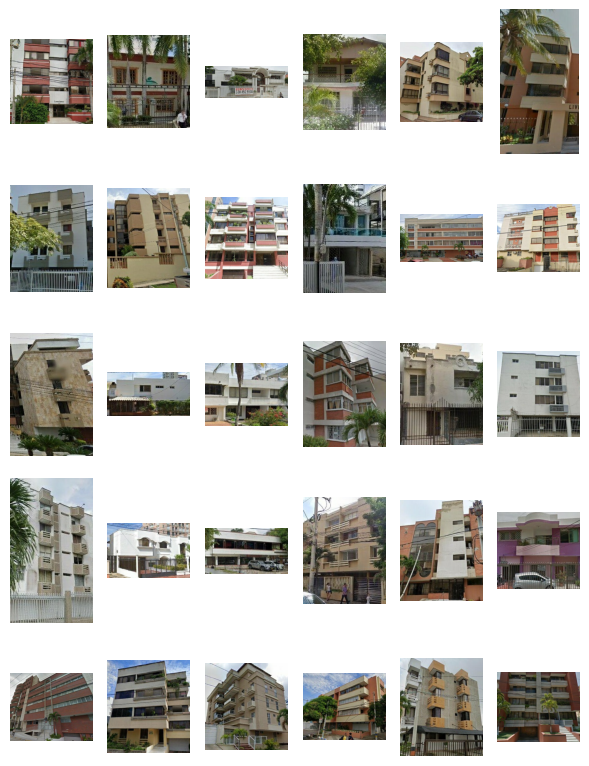

In [ ]:
# Image paths
train_data = os.listdir("/content/Training_age/edad_PR84")
image_paths = train_data[0:30]

dataset = tf.data.Dataset.from_tensor_slices(image_paths)

def load_and_preprocess_image(image_path):
    image = tf.io.read_file("/content/Training_age/edad_PR84/"+image_path)
    image = tf.image.decode_image(image, channels=3)
    return image.numpy()

images = [load_and_preprocess_image(image_path) for image_path in image_paths]

rows = 5
cols = 6

fig = plt.figure(figsize=(6, 8))

for i in range(len(images)):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.imshow(images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

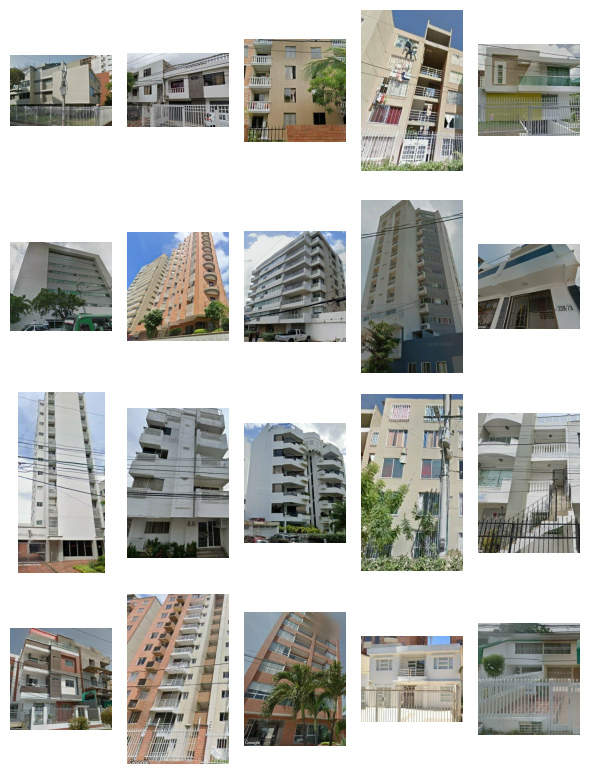

In [ ]:
# Image paths
train_data = os.listdir("/content/Training_age/edad_PR10")
image_paths = train_data[0:20]

dataset = tf.data.Dataset.from_tensor_slices(image_paths)

def load_and_preprocess_image(image_path):
    image = tf.io.read_file("/content/Training_age/edad_PR10/"+image_path)
    image = tf.image.decode_image(image, channels=3)
    return image.numpy()

images = [load_and_preprocess_image(image_path) for image_path in image_paths]

rows = 4
cols = 5

fig = plt.figure(figsize=(6, 8))

for i in range(len(images)):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.imshow(images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
for layer in xception.layers:
    layer.trainable = False
# This will let us use the default weights used by the imagenet.

In [ ]:
# Set the flatten layer.
x = Flatten() (xception.output)

prediction = Dense(len(labels), activation = 'softmax')(x)

# Create a model Object
model = Model(inputs = xception.input, outputs = prediction)

In [ ]:
model.compile (
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['categorical_accuracy', tf.keras.metrics.Recall(class_id = 1)]
)

In [ ]:
# Use the Image Data Generator

# from tensorflow.keras.proprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    horizontal_flip = True
)


In [ ]:
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SIZE,
    batch_size = 1,
    class_mode = 'categorical' # As we have more than 2 so using categorical.. for 2 we might have used binary.
)

test_set = train_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SIZE,
    batch_size = 1,
    shuffle=False,
    class_mode = 'categorical'
)

Found 1528 images belonging to 4 classes.
Found 388 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5)

history = model.fit(
    training_set,
    epochs = 30,
    steps_per_epoch = len(training_set),
    callbacks=[early_stopping]
)

Epoch 1/30
1528/1528 [==============================] - 66s 36ms/step - loss: 25.3702 - categorical_accuracy: 0.4954 - recall: 0.1988
Epoch 2/30
1528/1528 [==============================] - 48s 31ms/step - loss: 21.0226 - categorical_accuracy: 0.6080 - recall: 0.4036
Epoch 3/30
1528/1528 [==============================] - 48s 32ms/step - loss: 18.9941 - categorical_accuracy: 0.6545 - recall: 0.4578
Epoch 4/30
1528/1528 [==============================] - 48s 32ms/step - loss: 16.7268 - categorical_accuracy: 0.6963 - recall: 0.4880
Epoch 5/30
1528/1528 [==============================] - 50s 33ms/step - loss: 15.4778 - categorical_accuracy: 0.7369 - recall: 0.6084
Epoch 6/30
1528/1528 [==============================] - 48s 32ms/step - loss: 12.1022 - categorical_accuracy: 0.7605 - recall: 0.6386
Epoch 7/30
1528/1528 [==============================] - 48s 31ms/step - loss: 12.6920 - categorical_accuracy: 0.7880 - recall: 0.6446
Epoch 8/30
1528/1528 [==============================] - 48s 32

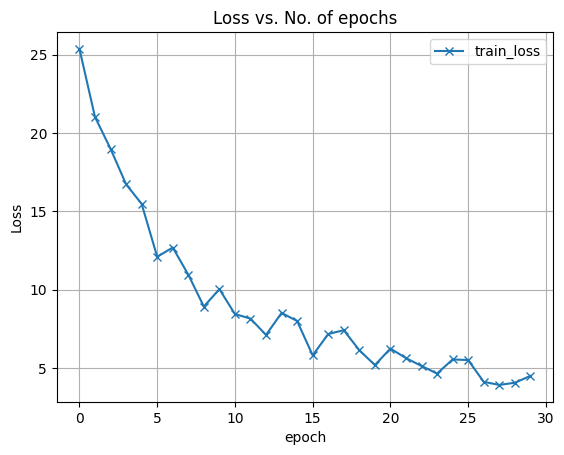

In [ ]:
# Plot the Loss
plt.plot(history.history['loss'],'-x', label = 'train_loss')
#plt.plot(history.history['val_loss'],'-x', label ='val loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss vs. No. of epochs')
plt.grid(True)
plt.legend()
plt.show()

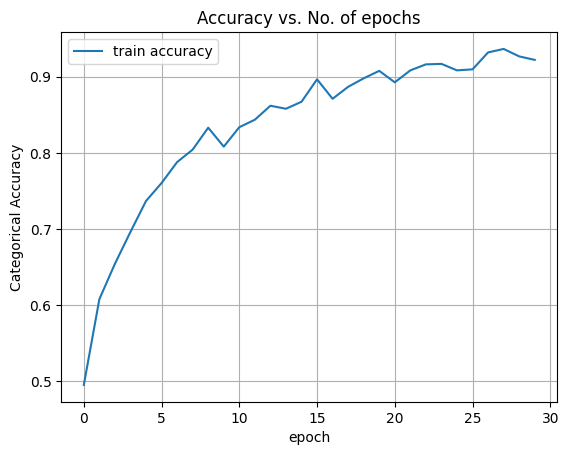

In [ ]:
# Plot the Accuracy
plt.plot(history.history['categorical_accuracy'], label = 'train accuracy')
#plt.plot(history.history['val_binary_accuracy'], label ='val categorical_accuracy')
plt.xlabel('epoch')
plt.ylabel('Categorical Accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.grid(True)
plt.legend()
plt.show()

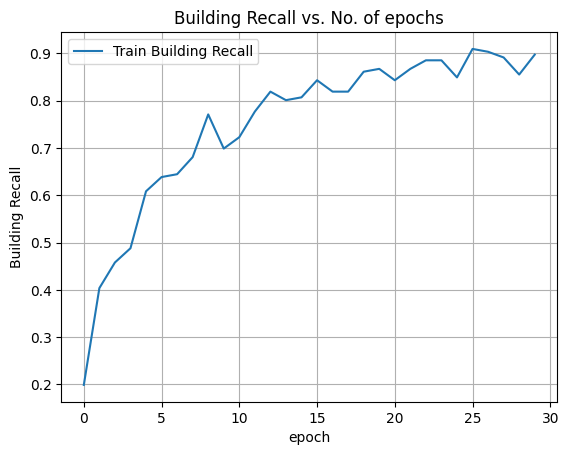

In [ ]:
# Plot the Accuracy
plt.plot(history.history['recall'], label = 'Train Building Recall')
#plt.plot(history.history['val_recall'], label ='Vrain Building Recall')
plt.xlabel('epoch')
plt.ylabel('Building Recall')
plt.title('Building Recall vs. No. of epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
prediction = model.predict(test_set)
preds = prediction
prediction = np.argmax(prediction, axis = 1)

388/388 [==============================] - 13s 30ms/step


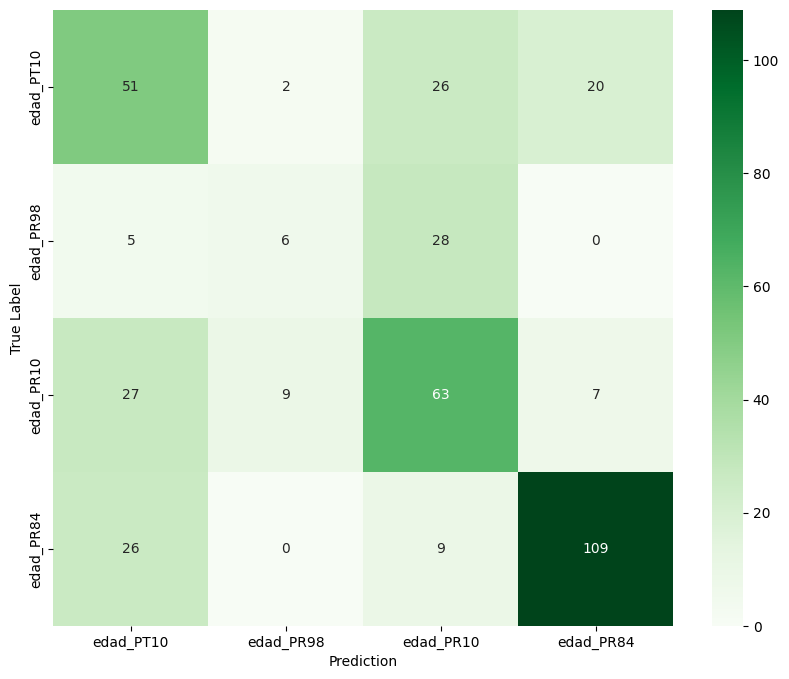

In [ ]:
def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels,annot=True, fmt='g',
                cmap=sns.color_palette("Greens", as_cmap=True))
    plt.xlabel('Prediction')
    plt.ylabel('True Label')
    plt.show()

confusion_mtx = tf.math.confusion_matrix(
    test_set.labels,
    prediction,
    num_classes=len(labels))

show_confusion_matrix(confusion_mtx, labels)

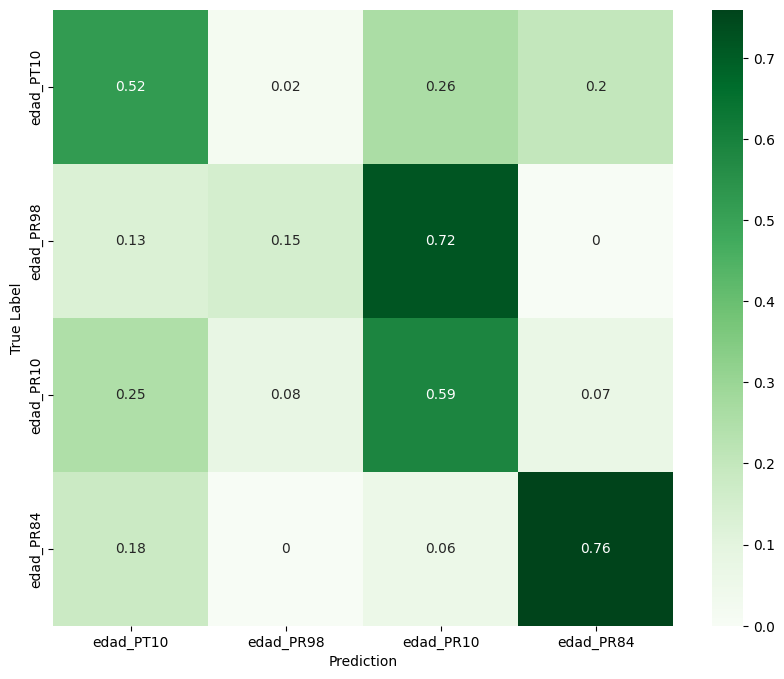

In [ ]:
cm_norm = np.zeros((confusion_mtx.shape[0],confusion_mtx.shape[1]))

for i in range(confusion_mtx.shape[0]):
    total_label = sum(confusion_mtx[i,:])
    for j in range(confusion_mtx.shape[1]):
        if total_label > 0:
            cm_norm[i,j] = np.round(confusion_mtx[i,j]/total_label,2)

show_confusion_matrix(cm_norm, labels)

1/1 [==============================] - 0s 23ms/step
Probability: [[0. 0. 1. 0.]]
Class: edad_PR10


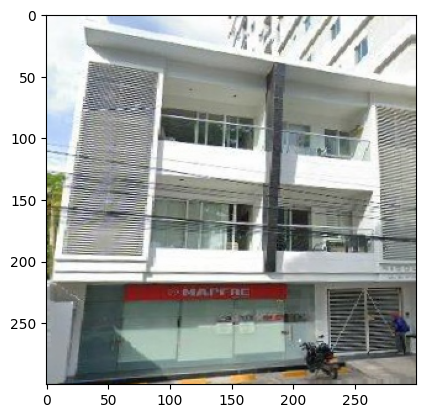

In [ ]:
img, label = test_set.next()
x = image.img_to_array(img[0])
x = np.expand_dims(x, axis = 0)
pred_class = model.predict(x)
a = int(np.argmax(pred_class, axis = 1))
story = labels[a]
print("Probability:",pred_class)
print("Class:",story)
plt.figure()
plt.imshow(img[0])
plt.show()

* Clase real PR10

1/1 [==============================] - 0s 24ms/step
Probability: [[0. 0. 1. 0.]]
Class: edad_PR10


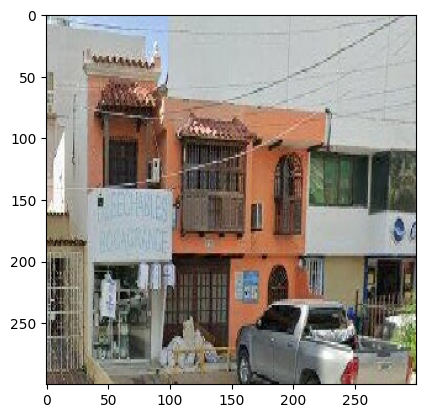

In [ ]:
path = "/content/Test_age/edad_PR84/156155.jpg"
img = image.load_img(path, target_size = [300,300])
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
img_data = preprocess_input(x)
pred_class = model.predict(img_data)
a = int(np.argmax(pred_class, axis = 1))
story = labels[a]
print("Probability:",pred_class)
print("Class:",story)

* Clase real PR84